In [53]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

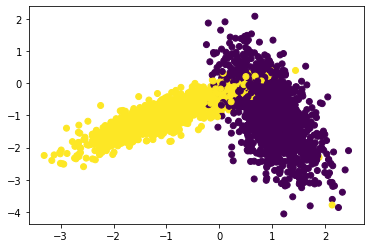

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

In [112]:
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):

  # generate 10 unique values between 1 and param_range
  # https://docs.python.org/3/library/random.html#random.sample
  try:
    k_values = sorted(random.sample(range(1, param_range), k=10))
    # k_values = [3,5,7,9,11,13,15,17,19,21,23]
  except:
    print('param_range should be > 10')
  # dividing the dataset into 'folds' parts
  split_indices = numpy.array_split(range(0, len(x_train)), folds)
  

  avg_trainscore_folds = []
  avg_testscore_folds = []

  for k in tqdm(k_values):
    
    test_scores=  []
    train_scores = []
    for i in range(0, folds):
      # selecting ith part as test indices
      test_indices = split_indices[i]
      # selecting the rest as train indices
      train_indices = list(set(list(range(1, len(x_train)))) - set(test_indices))
      
      # splitting the data to form test and train features and labels
      X_train = x_train[train_indices]
      Y_train = y_train[train_indices]
      X_test = x_train[test_indices]
      Y_test = y_train[test_indices]

      # fitting the model
      classifier.n_neighbors = k
      classifier.fit(X_train,Y_train)

      # storing the predicted values & accuracy in test - cross validation
      Y_predicted = classifier.predict(X_test)
      test_scores.append(accuracy_score(Y_test, Y_predicted))
      
      # storing the predicted values in train & accuracy - test validation
      Y_predicted = classifier.predict(X_train)
      train_scores.append(accuracy_score(Y_train, Y_predicted))
      

    # storing the average of the above accuracies
    avg_testscore_folds.append(np.mean(np.array(test_scores)))
    avg_trainscore_folds.append(np.mean(np.array(train_scores)))

  return avg_testscore_folds, avg_trainscore_folds, k_values
      


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


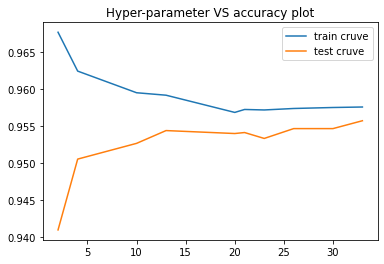

In [115]:
clf = KNeighborsClassifier()

param_range = 50
folds = 3
testscores,trainscores, k_values = RandomSearchCV(X_train, y_train, clf, param_range, folds)

plt.plot(k_values,trainscores, label='train cruve')
plt.plot(k_values,testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

### Observation

- We can see that the optimum number for k is approximately 26

Lets plot decision surface with k = 26

In [116]:
# Reference AAIC ref nb
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

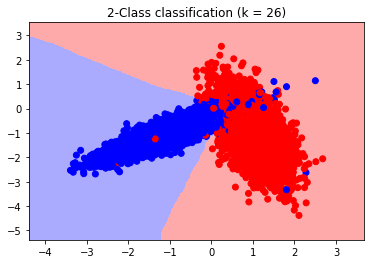

In [117]:
from matplotlib.colors import ListedColormap
clf = KNeighborsClassifier(n_neighbors = 26)
clf.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, clf)

#### Checking accuracy on unseen data - test data

In [118]:
Y_predicted = clf.predict(X_test)
accuracy_score(y_test, Y_predicted)

0.9684

### Final Observation

- The model works with an accuracy of 96.84% on unseen data